# Trading System Test and Exploration

This notebook tests the complete trading system with all Tier 1 improvements:
- Walk-forward validation
- Volatility-scaled transaction costs
- Visualization (equity curves + drawdown)
- Stop-loss risk management

## Setup


In [1]:
import sys
import os

# Add project root to path
# In Jupyter, getcwd() returns the directory where jupyter was started (usually project root)
# If we're in notebooks/, go up one level
current_dir = os.getcwd()
if current_dir.endswith('notebooks'):
    project_root = os.path.dirname(current_dir)
else:
    project_root = current_dir

# Add project root to Python path
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Verify the path is correct
print(f"Current directory: {current_dir}")
print(f"Project root: {project_root}")
print(f"Python path includes project root: {project_root in sys.path}")

from src.train_model import train_and_evaluate, walk_forward_validation
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set up plotting
%matplotlib inline
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('seaborn-darkgrid')  # Fallback for older matplotlib
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Setup complete! All imports successful.")


Current directory: /Users/vardhan/firsttrading/notebooks
Project root: /Users/vardhan/firsttrading
Python path includes project root: True
✓ Setup complete! All imports successful.


## Test 1: Single Stock with Full Pipeline

Run the full pipeline with single train/test split to see all features.


In [2]:
# Run full pipeline on AAPL
stock = 'AAPL'
prob_model_rf, prob_model_lr, return_model_lr, return_model_gb = train_and_evaluate(stock, "2y")


[*********************100%***********************]  1 of 1 completed



=== Baseline Models ===
Always predict up: 54.17%
Predict based on yesterday's return: 57.29%

=== Basic Accuracy (Reference) ===
Random Forest Accuracy: 47.92%
Logistic Regression Accuracy: 54.17%

=== Win Rate by Probability Bucket (Random Forest Calibrated) ===
Low (<0.45)         :   37 samples, Avg P(up): 0.417, Win rate: 48.65%
Neutral (0.45-0.55) :   57 samples, Avg P(up): 0.534, Win rate: 57.89%
Weak (0.55-0.60)    :    2 samples, Avg P(up): 0.559, Win rate: 50.00%

Coverage: 40.6% of days flagged (outside neutral zone 0.45-0.55)

=== Feature Importance Analysis ===
     Feature  RF_Importance  LR_Coefficient
         rsi       0.132759        0.496289
         ma5       0.132507       -0.995300
 price_to_ma       0.127255       -0.151518
volume_ratio       0.123695       -0.089118
        ma20       0.123258        0.851269
    momentum       0.121508       -0.009645
     returns       0.120204        0.066017
  volatility       0.118814       -0.109107

=== Error Analysis ==

## Test 2: Walk-Forward Validation

Test walk-forward validation to see more realistic performance across multiple windows.


In [3]:
# Test walk-forward validation on AAPL
stock = 'AAPL'
results = walk_forward_validation(stock, "2y", train_size=0.7, test_size=0.1, step=0.1, verbose=True)


[*********************100%***********************]  1 of 1 completed



=== Walk-Forward Validation: AAPL ===
Total data points: 480
Initial train size: 336 (70%)
Test window size: 48 (10%)
Step size: 48 (10%)
Number of windows: 3

--- Window 1: Train [0:336], Test [336:384] ---
  Sharpe: 4.45, Return: 16.25%, Drawdown: 2.50%, Trades: 11 (Long: 11, Short: 0)

--- Window 2: Train [0:384], Test [384:432] ---
  Sharpe: 4.01, Return: 11.02%, Drawdown: 1.68%, Trades: 11 (Long: 6, Short: 5)

--- Window 3: Train [0:432], Test [432:480] ---
  Sharpe: 2.48, Return: 4.86%, Drawdown: 2.84%, Trades: 25 (Long: 25, Short: 0)

=== Walk-Forward Summary: AAPL ===
Number of windows: 3
Mean Sharpe Ratio: 3.64 (std: 0.84)
Mean Total Return: 10.71% (std: 4.66%)
Mean Max Drawdown: 2.34%
Mean Hit Rate: 72.30%


## Test 3: View Generated Plots

Check the plots directory for generated visualizations (equity curves and drawdown plots).


Found 2 plot files:

AAPL_long_short_optimized.png:


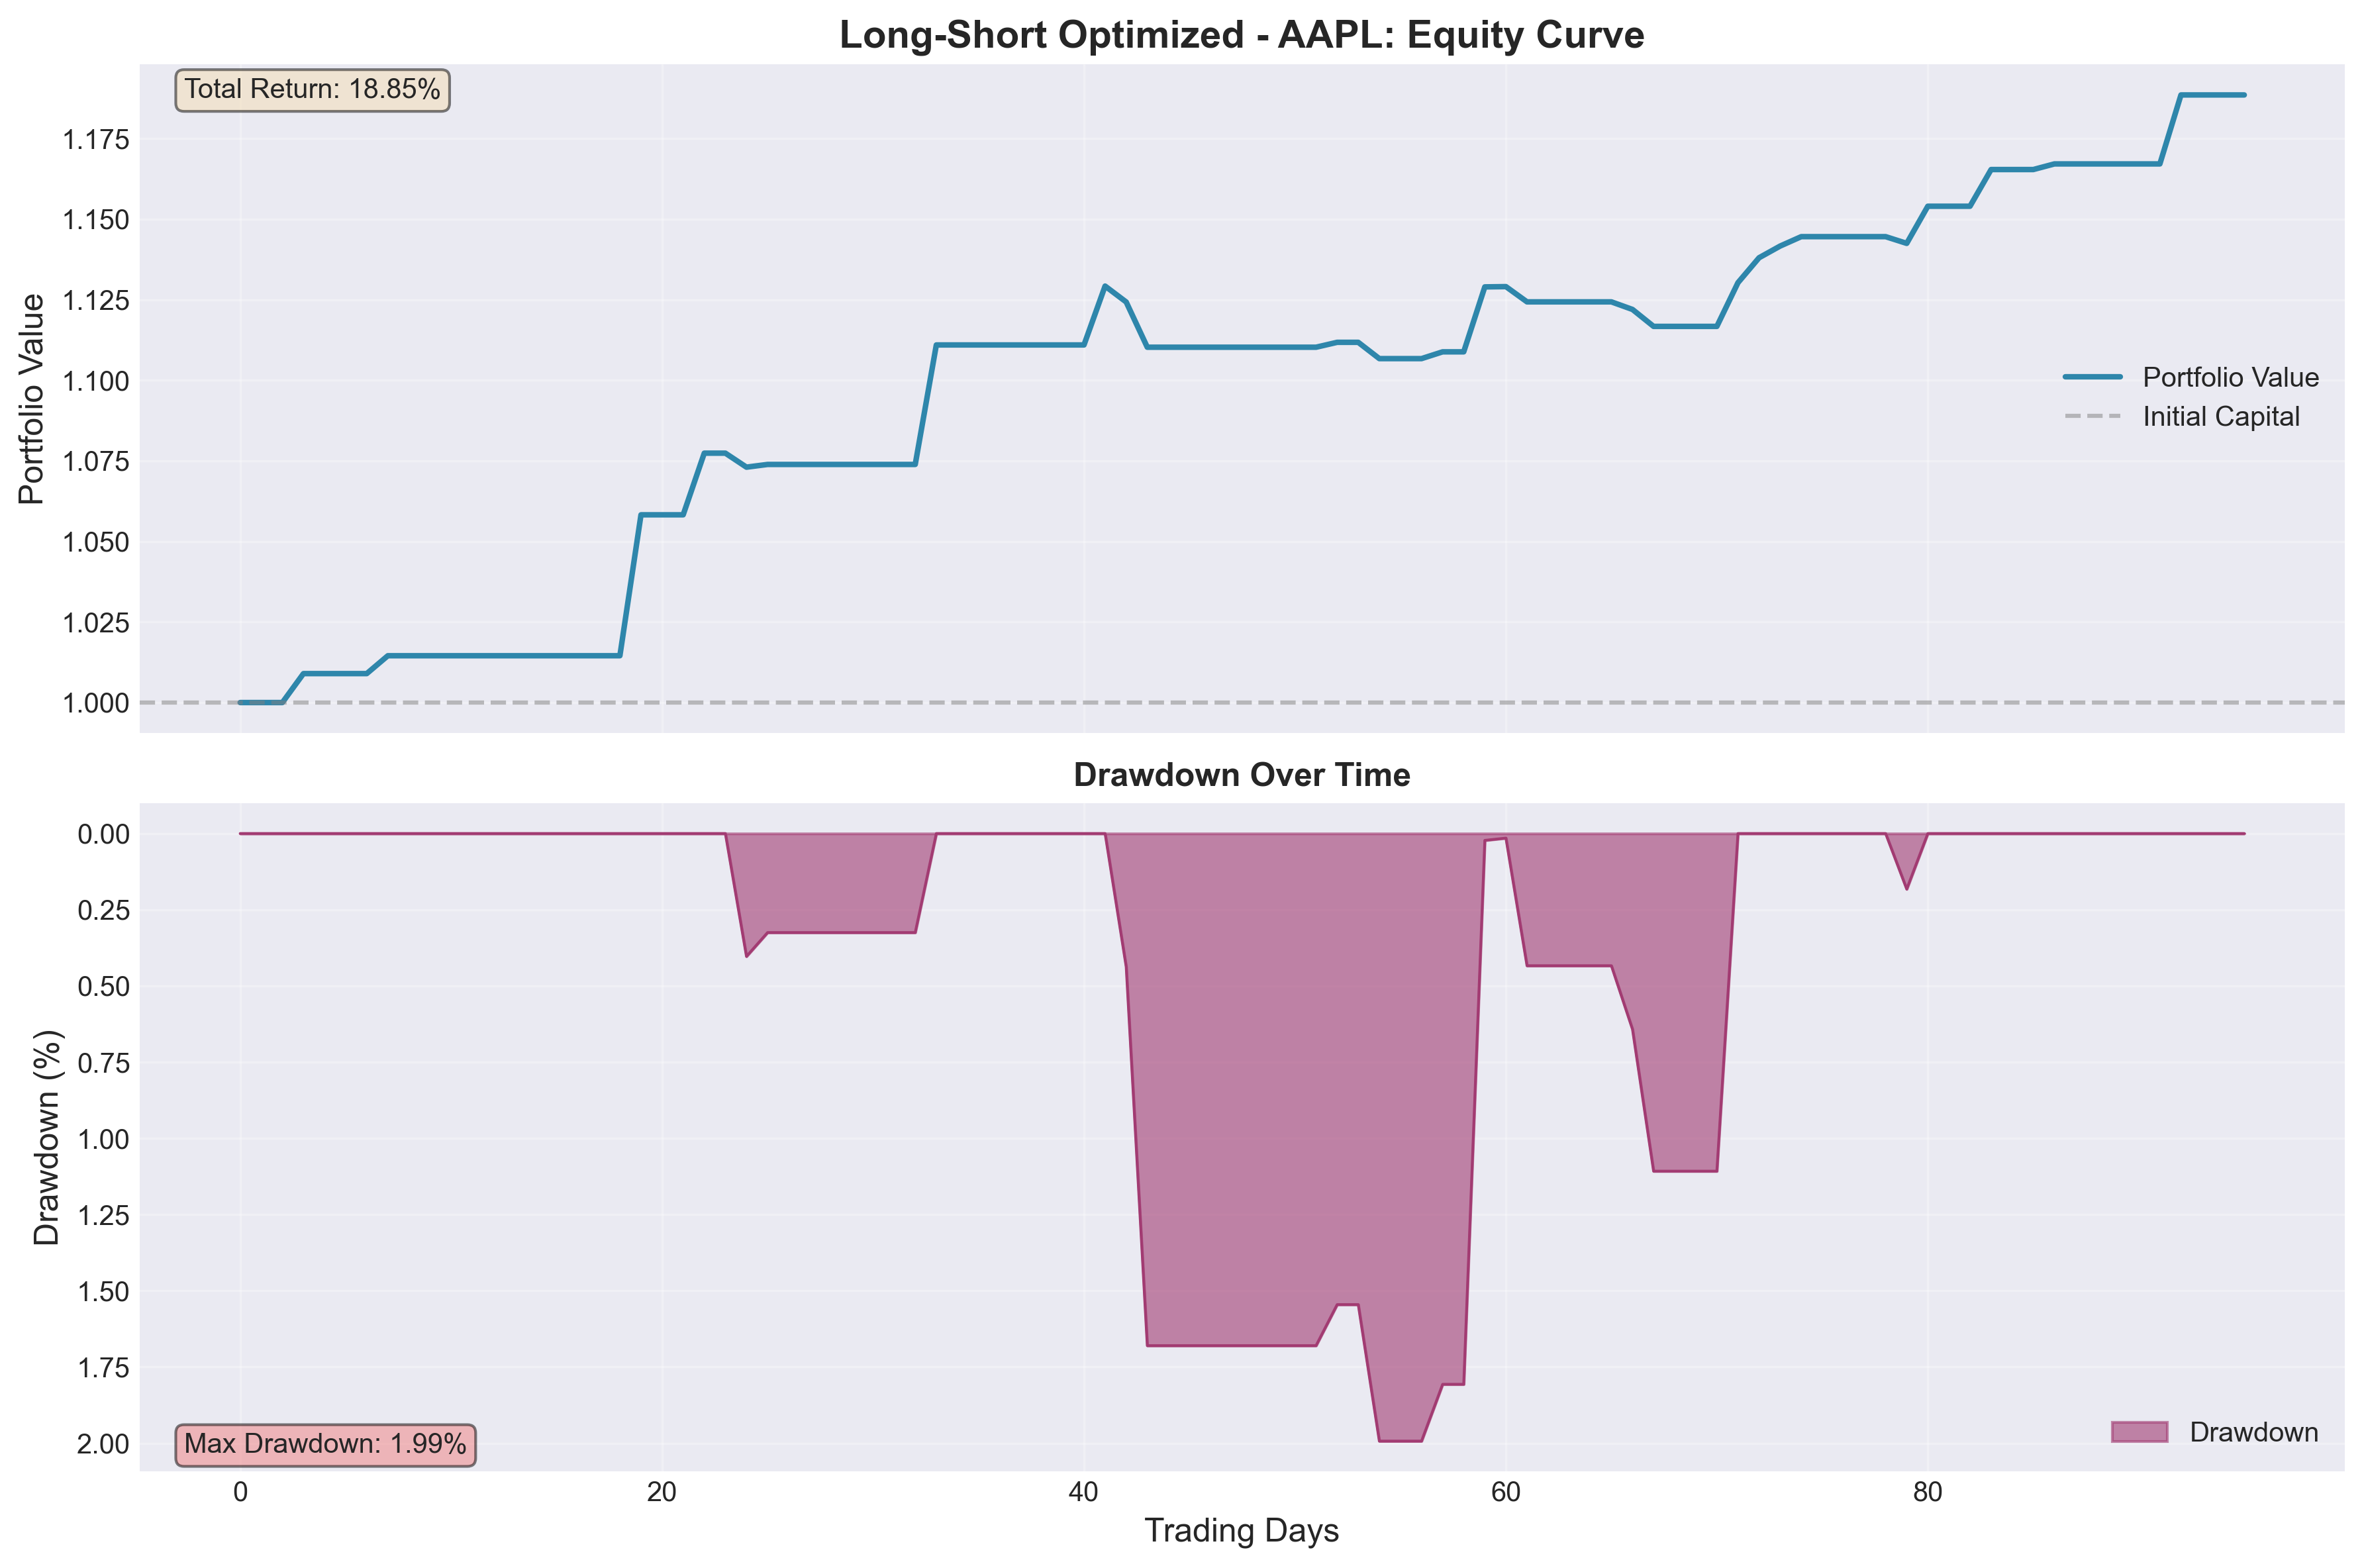


AAPL_strategy_comparison.png:


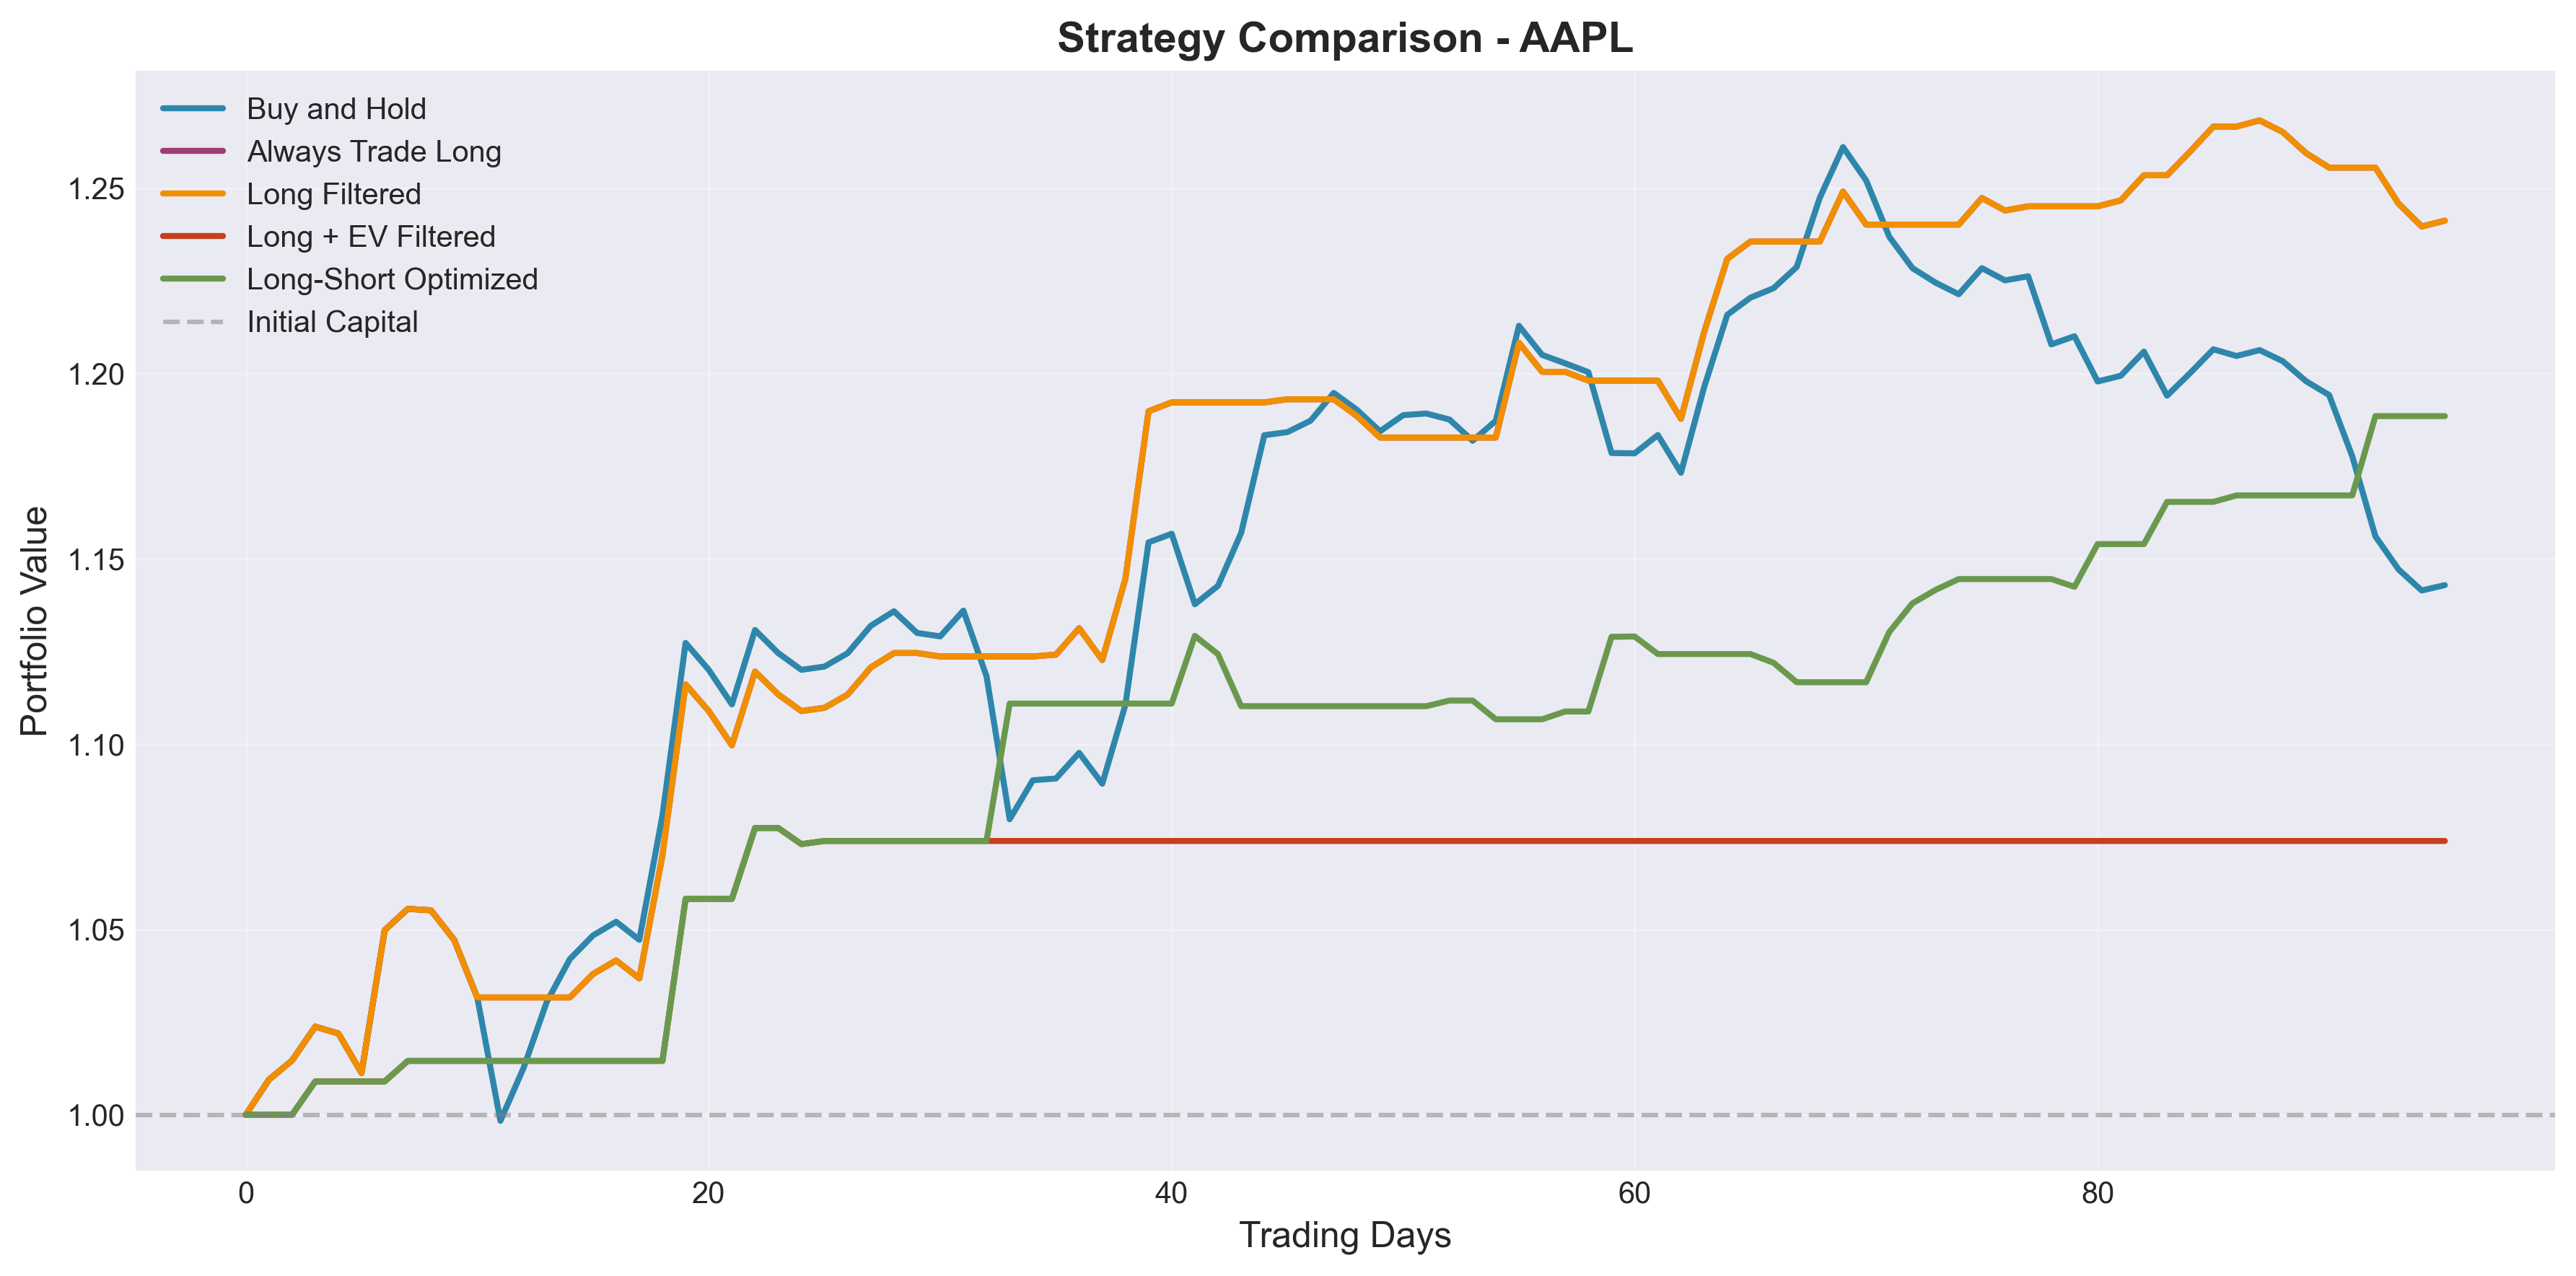

In [4]:
import os
from IPython.display import Image, display

plots_dir = 'plots'
if os.path.exists(plots_dir):
    plot_files = [f for f in os.listdir(plots_dir) if f.endswith('.png')]
    print(f"Found {len(plot_files)} plot files:")
    for plot_file in sorted(plot_files):
        plot_path = os.path.join(plots_dir, plot_file)
        print(f"\n{plot_file}:")
        display(Image(plot_path))
else:
    print(f"Plots directory '{plots_dir}' not found. Run train_and_evaluate() first.")


## Notes

- **Walk-forward validation** is more realistic but takes longer
- **Single split** is faster for development/testing  
- **Plots** are saved to `plots/` directory automatically
- **Stop-loss** is set to 2% by default (configurable in `train_and_evaluate()`)
- **Transaction costs** are volatility-scaled (base 0.1%, multiplier 2.0)
